In [1]:

import numpy as np
import matplotlib.pyplot as plt
import random as random
import math as math
from WeinerGeneratorNumba import getWeiner, getWeinerSubset, constructWeinerSubset
from tqdm.notebook import trange, tqdm
from numba import njit
from scipy.optimize import curve_fit

b = -0.05

t0 = 0
tend = 1
steps = 100000
dt = (tend-t0)/steps
h = 1.0
threshold = h/2
Kbar = 1.0

baseSteps = 1000000
Tend = 10
nRealizations = 5

def K(z):
    if z <= threshold:
        K = z*(h-2*z)*Kbar
    else:
        K = (h-z)*(-h+2*z)*Kbar
    return K
    
def dKdz(z):
    if z <= threshold:
        dKdz = h-4*z
    else:
        dKdz = 3*h-4*z
    return dKdz

def dgdz(z):
    #print(z)
    if z < threshold and z > 0:
        dgdz = math.sqrt(2) * (h - 4 * z) / (2 * math.sqrt(z * (h - 2 * z)))
    elif z > threshold and z < h:
        dgdz = math.sqrt(2) * (3 * h - 4 * z) / (2 * math.sqrt(-h**2 + 3 * h * z - 2 * z**2))
    else:
        dgdz = 0
    return dgdz

class Particle():
    def __init__(self, z):
        self.z = z

    
    def simulate(self, ts, dws, dt):
        """
        Optimized simulation using static simulateNumba
        """
        self.dt = dt
        self.ts = ts
        
        self.zs =self.simulateNumba(self.z, ts, dws, dt)

        return self.zs

    def simulatePython(self, ts, dws, dt):
        """
        Slow pure Python simulation
        """
        self.dt = dt
        self.ts = ts
        self.zs = []
        for index, t in enumerate(ts):
            #Story history
            self.zs.append(self.z)

            #Advance
            z0 = self.z
            z1 = z0 + dKdz(z0)*dt + math.sqrt(2*K(z0))*dws[index] #last dws gets used here but the last resulting zs doesn't get stored

            #Store result
            self.z = z1 

            #Correct if out of bounds
            self.correctBounds()
        return self.zs

    def correctBounds(self):
        if abs(self.z) > 2*h:
            print("Severe out of bounds")
            exit()
        if self.z < 0:
            self.z = - self.z
        if self.z > h:
            self.z = 2*h - self.z
        return

    @staticmethod
    @njit
    def simulateNumba(z, ts, dws, dt):
        #Optimized version using Numba (just in time compiler)
        zs = []
        for index, t in enumerate(ts):
            #Story history
            zs.append(z)
            z0 = z

            #calc K(z0)
            if z0 <= threshold:
                K = z0*(h-2*z0)*Kbar
            else:
                K = (h-z0)*(-h+2*z0)*Kbar

            #calc dKdz(z0)
            if z0 <= threshold:
                dKdz = h-4*z0
            else:
                dKdz = 3*h-4*z0

            #K = 1 #z0
            #dKdz = 0 #1

            #Advance
            z1 = z0 + dKdz*dt + math.sqrt(2*K)*dws[index] #last dws gets used here but the last resulting zs doesn't get stored

            #Store result
            z = z1 
        
            if abs(z) > 2*h:
                print("WARNING SEVERE OUT OF BOUNDS")
            if z < 0:
                z = -z
            if z > h:
                z = 2*h - z
        return zs



    def simulate_Milstein(self,ts,dws,dt):
        zs = []
        for index, t in enumerate(ts):
            z0 = self.z
            # z1 = z0 + dKdz(z0)*dt + math.sqrt(2*K(z0))*random.gauss(0,1)*math.sqrt(dt)#*randomFactor # Euler
            z1 = z0 + dKdz(z0) * dt + math.sqrt(2 * K(z0)) * random.gauss(0,1) * math.sqrt(dt) + 0.5 * math.sqrt(2 * K(z0)) * dgdz(z0) * (random.gauss(0,1)**2 * dt - dt)
            # print(z0, z1)
            if z1 < 0:
                z1 = -z1
            if z1 > h:
                # z1 = 2*h-z1
                z1 = 0.99 # If using Milstein the above won't assure the particles stay within range
            self.z = z1 
        return z1
        


# Generating tracks

## Tracks used in this analysis:

In [2]:
loacalBaseSteps = 1000000
localTend = 10
localNRealizations = 5

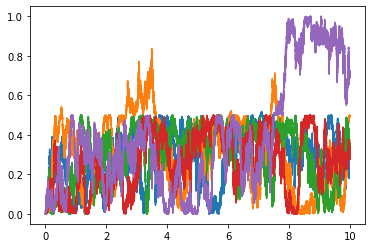

In [3]:
def plotRealization(realization):
    ts, ws, dws, dt = getWeiner(loacalBaseSteps,localTend, realization)
    particle = Particle(0)
    zs = particle.simulate(ts, dws, dt)

    plt.plot(ts,zs)

for i in range(localNRealizations):
    plotRealization(i)

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\serva\AppData\Local\Temp/ipykernel_1540/1282166078.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  zssMeans = np.array(zssMeans)


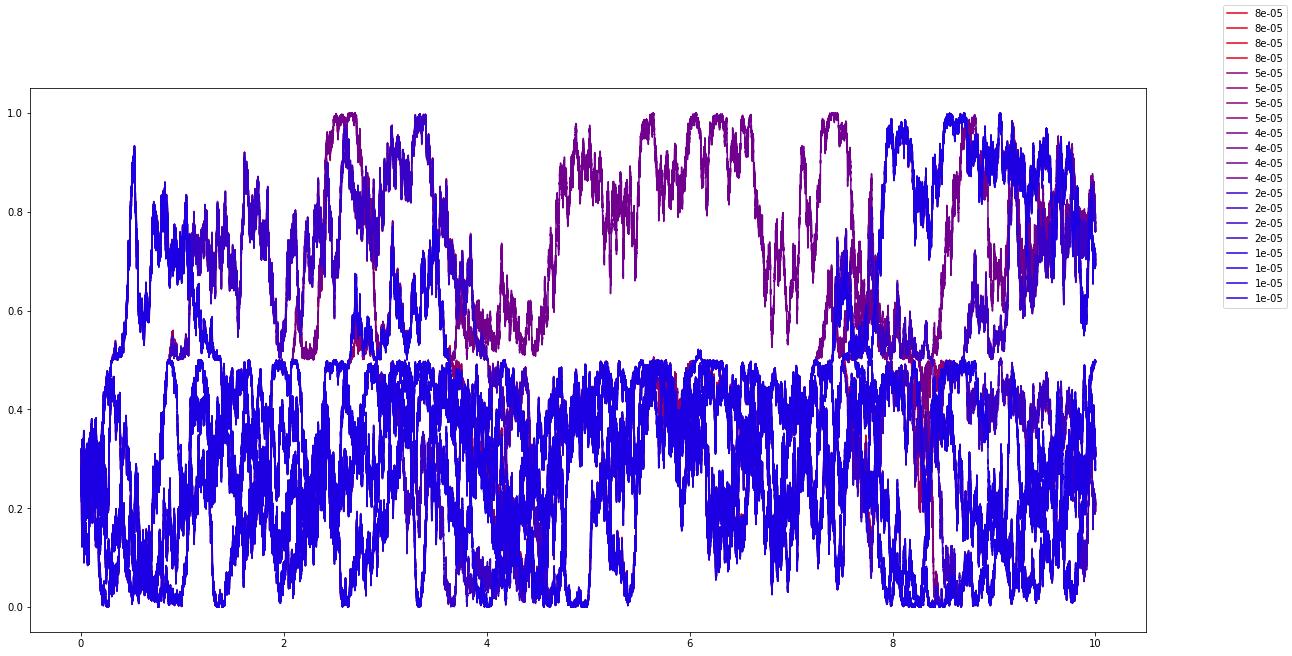

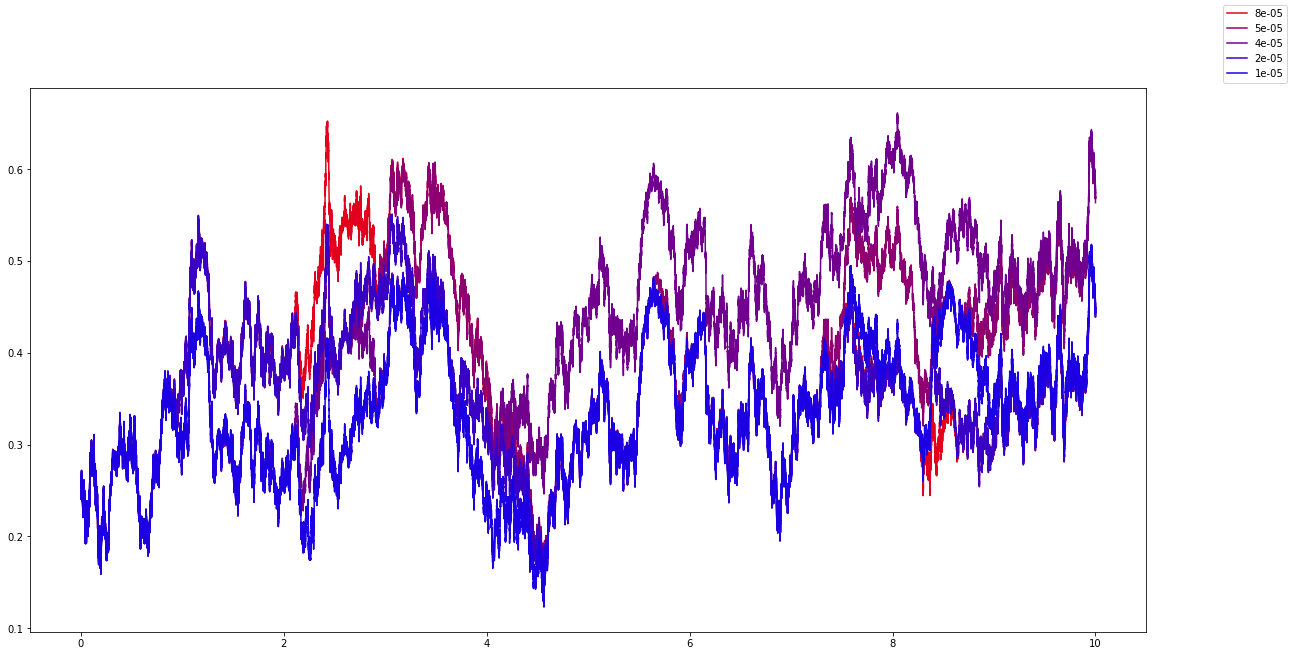

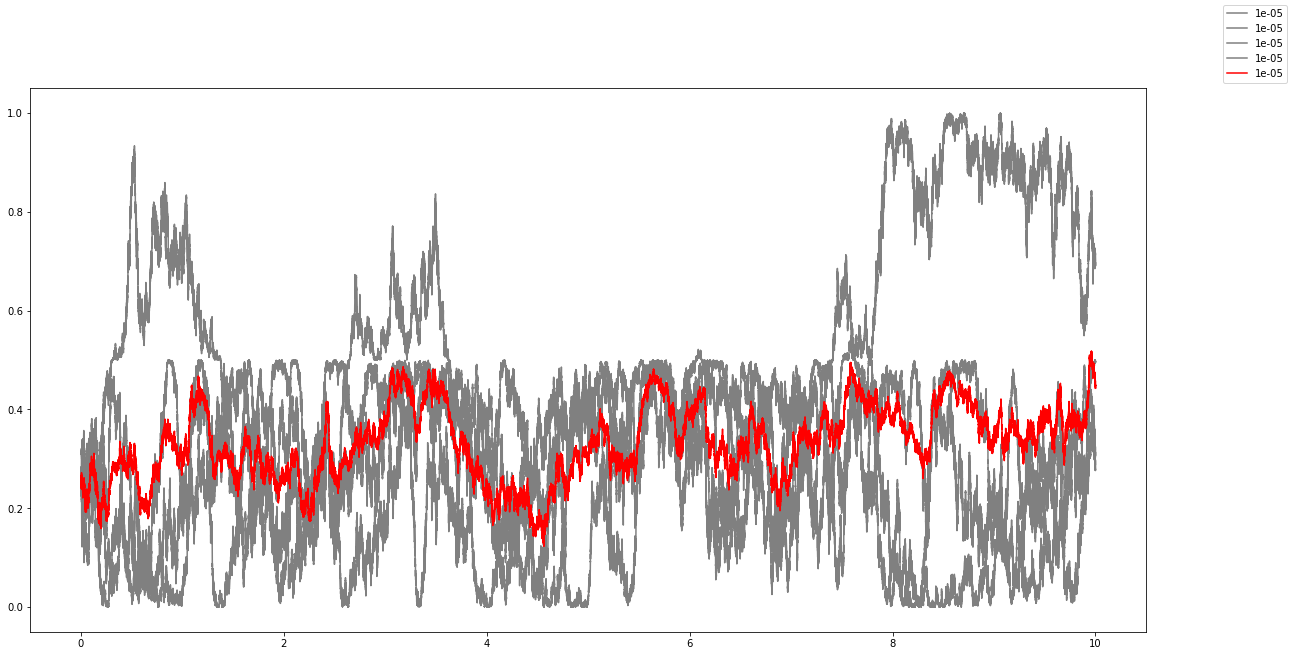

In [4]:
fig_all = plt.figure(figsize=(20,10))
fig_mean = plt.figure(figsize=(20,10))
fig_single = plt.figure(figsize=(20,10))
ax1 = fig_all.gca()
ax2 = fig_mean.gca()
ax3 = fig_single.gca()

iterlist = np.arange(1,10)
iterlist = iterlist[::-1] #reverse iterlist to plot highest resolution to lowest resolution
maxnth = iterlist[0]

realizationDeltas = []

nths = []
for i in iterlist:
    if baseSteps%i == 0:
        nths.append(i)


zssMeans = []
for nth in tqdm(nths):
    zss = []
    for realization in np.arange(1,localNRealizations):
        ts, ws, dws, dt = getWeinerSubset(nth, loacalBaseSteps, localTend, realization)
        particle = Particle(0.25)
        zs = particle.simulate(ts, dws, dt)
        zss.append(np.array(zs))

        ax1.plot(ts,zs, label = dt, color = (1-(maxnth-nth)/maxnth, 0, 1-nth/maxnth))

        if nth == 1:
            ax3.plot(ts,zs, label = dt, color = "grey")

    zssMean = np.mean(np.array(zss), axis = 0)
    ax2.plot(ts, zssMean, label = dt, color = (1-(maxnth-nth)/maxnth, 0, 1-nth/maxnth))
    if nth == 1:
        ax3.plot(ts,zssMean, label = dt, color = "red")

    zssMeans.append(np.array(zssMean))

zssMeans = np.array(zssMeans)

fig_single.legend(loc = "upper right")
fig_all.legend(loc = "upper right")
fig_mean.legend(loc = "upper right")
        

## Tracks without IO

In [9]:
localBaseSteps = 1000
localTend = 10
localNRealizations = 5

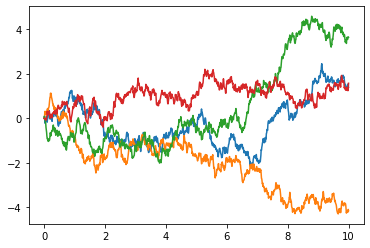

In [10]:
iterlist = np.arange(1,10)
maxnth = iterlist[-1]

realizationDeltas = []

nths = []
for i in iterlist:
    if baseSteps%i == 0:
        nths.append(i)

realizationDatas = []
for realization in np.arange(1,localNRealizations):
    baseTs, baseWs, baseDws, baseDt = getWeiner(localBaseSteps, localTend, realization, noIO = True)
    realizationData = {'baseTs': baseTs, 'baseWs': baseWs,'baseDws': baseDws,'baseDt': baseDt}
    realizationDatas.append(realizationData)
    plt.plot(baseTs, baseWs)

[1, 2, 4, 5, 8]


  0%|          | 0/5 [00:00<?, ?it/s]

(0.0, 1.0)

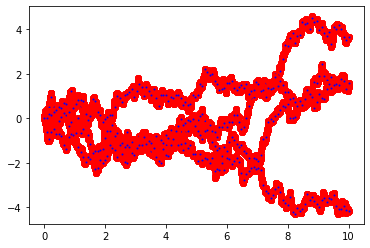

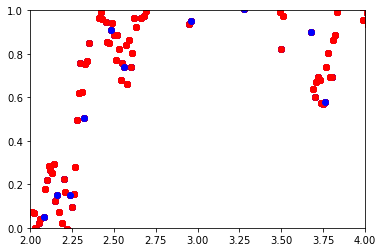

In [15]:
fig1 = plt.figure()
fig2 = plt.figure()
ax1 = fig1.gca()
ax2 = fig2.gca()

print(nths)
for nth in tqdm(nths):
    zss = []
    
    for realization in np.arange(1,localNRealizations):
        ts, ws, dws, dt = constructWeinerSubset(
            nth, 
            realizationDatas[realization-1]['baseTs'], 
            realizationDatas[realization-1]['baseWs'], 
            realizationDatas[realization-1]['baseDws'], 
            realizationDatas[realization-1]['baseDt']
        )

        ax1.scatter(realizationDatas[realization-1]['baseTs'], realizationDatas[realization-1]['baseWs'], color = 'red')
        ax1.scatter(ts, ws, color = 'blue', marker = 'o', s = 1.0)

        ax2.scatter(realizationDatas[realization-1]['baseTs'], realizationDatas[realization-1]['baseWs'], color = 'red')
        ax2.scatter(ts, ws, color = 'blue', marker = 'o')

ax2.set_xlim([2, 4])
ax2.set_ylim([0, 1])

In [3]:
localBaseSteps = 100000
localTend = 10
localNRealizations = 10

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\serva\AppData\Local\Temp/ipykernel_22764/4192270599.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  zssMeans = np.array(zssMeans)


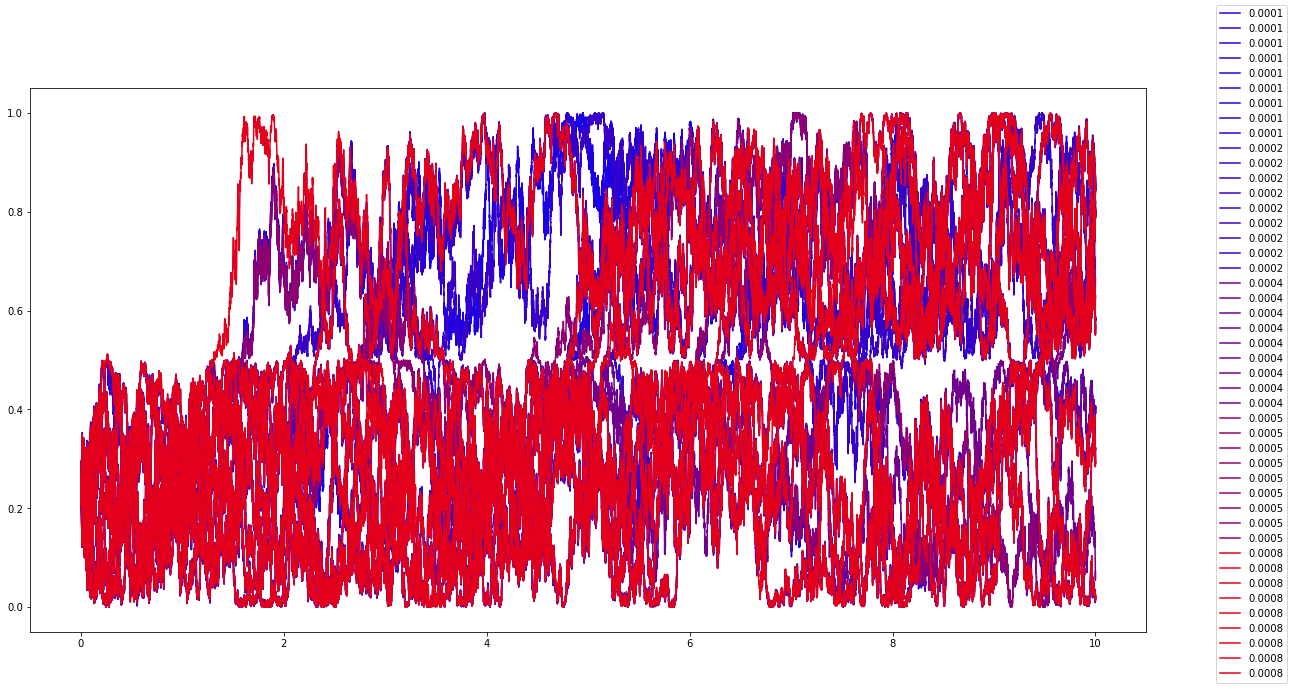

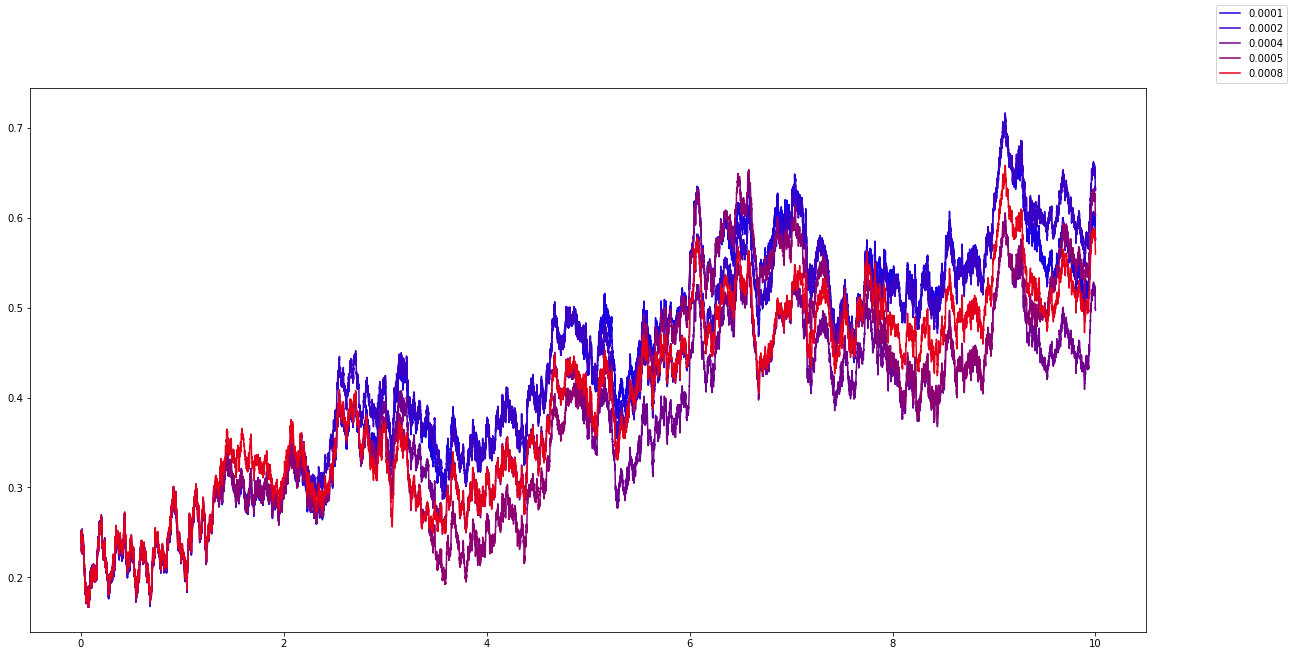

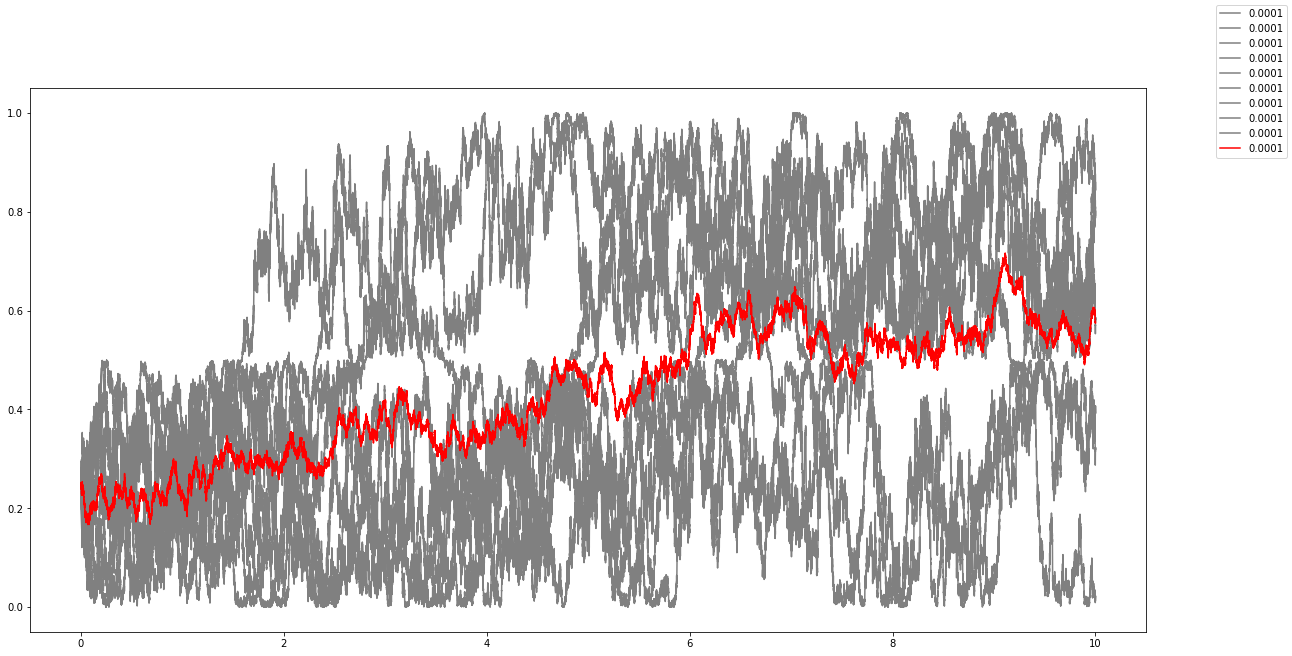

In [4]:
fig_all = plt.figure(figsize=(20,10))
fig_mean = plt.figure(figsize=(20,10))
fig_single = plt.figure(figsize=(20,10))
ax1 = fig_all.gca()
ax2 = fig_mean.gca()
ax3 = fig_single.gca()

iterlist = np.arange(1,10)
maxnth = iterlist[-1]

realizationDeltas = []

nths = []
for i in iterlist:
    if baseSteps%i == 0:
        nths.append(i)

realizationDatas = []
for realization in np.arange(1,localNRealizations):
    baseTs, baseWs, baseDws, baseDt = getWeiner(localBaseSteps, localTend, realization, noIO = True)
    realizationData = {'baseTs': baseTs, 'baseWs': baseWs,'baseDws': baseDws,'baseDt': baseDt}
    realizationDatas.append(realizationData)
    
zssMeans = []
for nth in tqdm(nths):
    zss = []
    
    for realization in np.arange(1,localNRealizations):
        ts, ws, dws, dt = constructWeinerSubset(
            nth, 
            realizationDatas[realization-1]['baseTs'], 
            realizationDatas[realization-1]['baseWs'], 
            realizationDatas[realization-1]['baseDws'], 
            realizationDatas[realization-1]['baseDt']
        )

        particle = Particle(0.25)
        zs = particle.simulate(ts, dws, dt)
        zss.append(np.array(zs))

        ax1.plot(ts,zs, label = dt, color = (1-(maxnth-nth)/maxnth, 0, 1-nth/maxnth))

        if nth == 1:
            ax3.plot(ts,zs, label = dt, color = "grey")

    zssMean = np.mean(np.array(zss), axis = 0)
    ax2.plot(ts, zssMean, label = dt, color = (1-(maxnth-nth)/maxnth, 0, 1-nth/maxnth))
    if nth == 1:
        ax3.plot(ts,zssMean, label = dt, color = "red")

    zssMeans.append(np.array(zssMean))

zssMeans = np.array(zssMeans)

fig_single.legend(loc = "upper right")
fig_all.legend(loc = "upper right")
fig_mean.legend(loc = "upper right")

In [33]:
localBaseSteps = 100000
localTend = 0.05
localNRealizations = 2500

  0%|          | 0/24 [00:00<?, ?it/s]

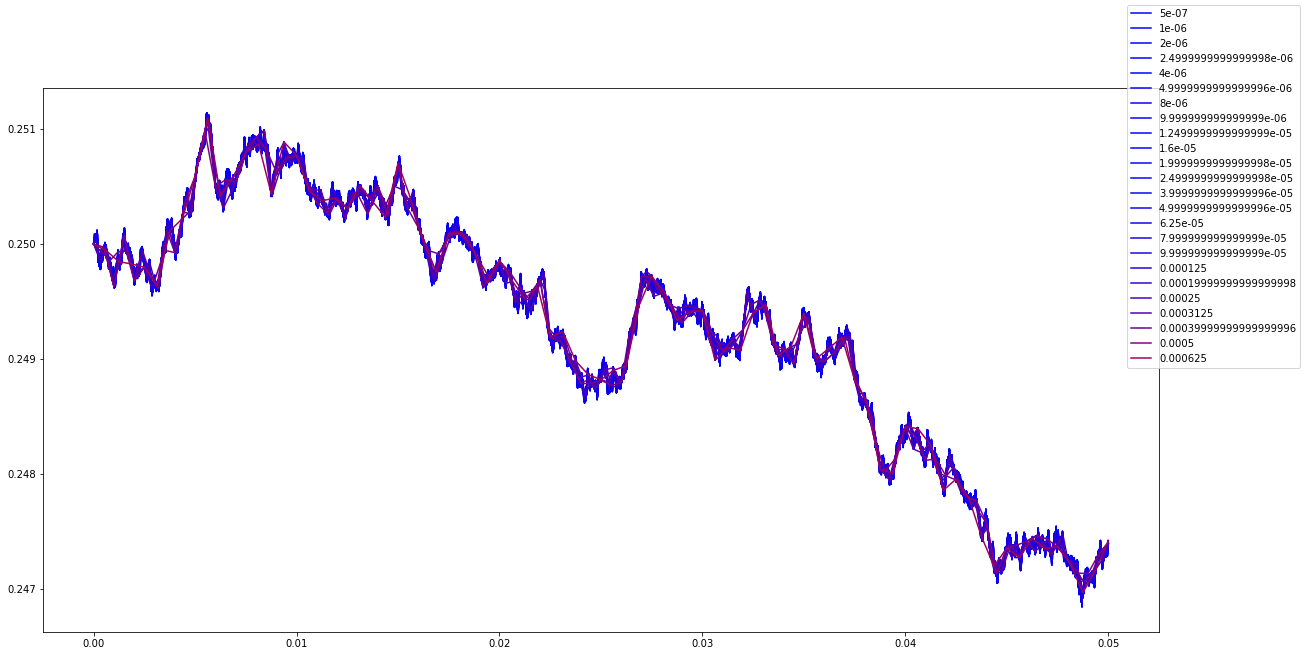

In [34]:
import pickle

#fig_all = plt.figure(figsize=(20,10))
fig_mean = plt.figure(figsize=(20,10))
#fig_single = plt.figure(figsize=(20,10))
#ax1 = fig_all.gca()
ax2 = fig_mean.gca()
#ax3 = fig_single.gca()

iterlist = np.arange(1,2000)
maxnth = iterlist[-1]

realizationDeltas = []

nths = []
for i in iterlist:
    if localBaseSteps%i == 0:
        nths.append(i)

#realizationDatas = []
for realization in np.arange(1,localNRealizations):
    baseTs, baseWs, baseDws, baseDt = getWeiner(localBaseSteps, localTend, realization, noIO = True)
    realizationData = {'baseTs': baseTs, 'baseWs': baseWs,'baseDws': baseDws,'baseDt': baseDt}
    #realizationDatas.append(realizationData)
    with open(f"realization{realization}.pkl", 'wb') as f:
        pickle.dump(realizationData, f)
    
pseudoParticles = []
resolutions = []
for nth in tqdm(nths):
    zss = []
    
    for realization in np.arange(1,localNRealizations):
        with open(f"realization{realization}.pkl", 'rb') as f:
            realizationData = pickle.load(f)

        ts, ws, dws, dt = constructWeinerSubset(
            nth, 
            realizationData['baseTs'], 
            realizationData['baseWs'], 
            realizationData['baseDws'], 
            realizationData['baseDt']
        )

        particle = Particle(0.25)
        zs = particle.simulate(ts, dws, dt)
        zss.append(np.array(zs))

        #ax1.plot(ts,zs, label = dt, color = (1-(maxnth-nth)/maxnth, 0, 1-nth/maxnth))

        #if nth == 1:
           #ax3.plot(ts,zs, label = dt, color = "grey")

    zssMean = np.mean(np.array(zss), axis = 0)
    ax2.plot(ts, zssMean, label = dt, color = (1-(maxnth-nth)/maxnth, 0, 1-nth/maxnth))
    #if nth == 1:
    #    ax3.plot(ts,zssMean, label = dt, color = "red")

    pseudoParticle = Particle(0)
    pseudoParticle.zs = zssMean
    pseudoParticle.ts = ts
    pseudoParticle.dt = dt
    pseudoParticles.append(pseudoParticle)
    resolutions.append(dt)

#fig_single.legend(loc = "upper right")
#fig_all.legend(loc = "upper right")
fig_mean.legend(loc = "upper right")

# Weak error convergence


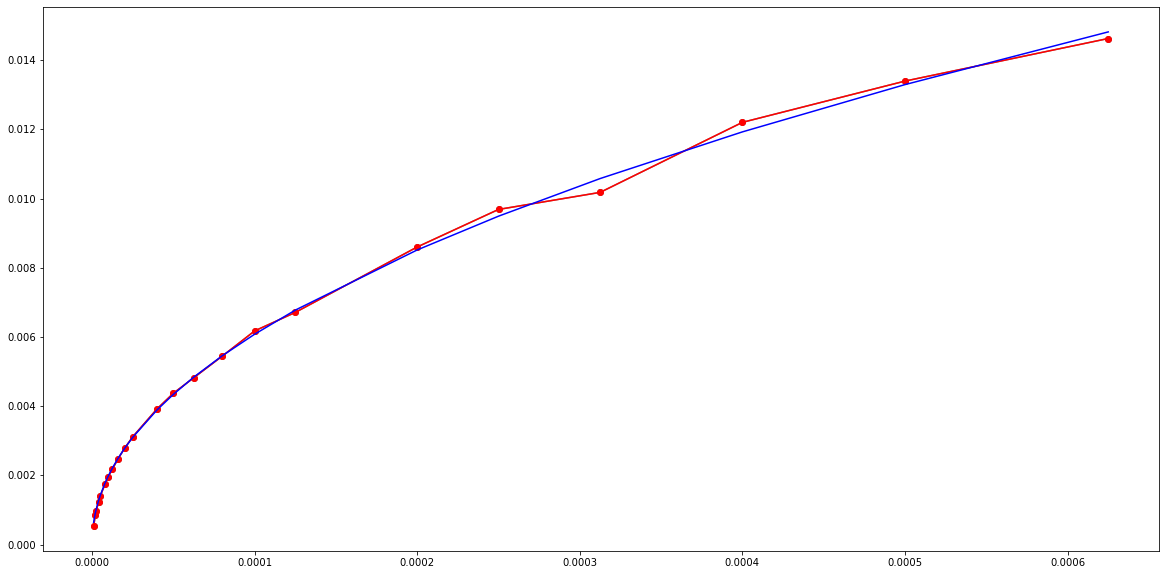

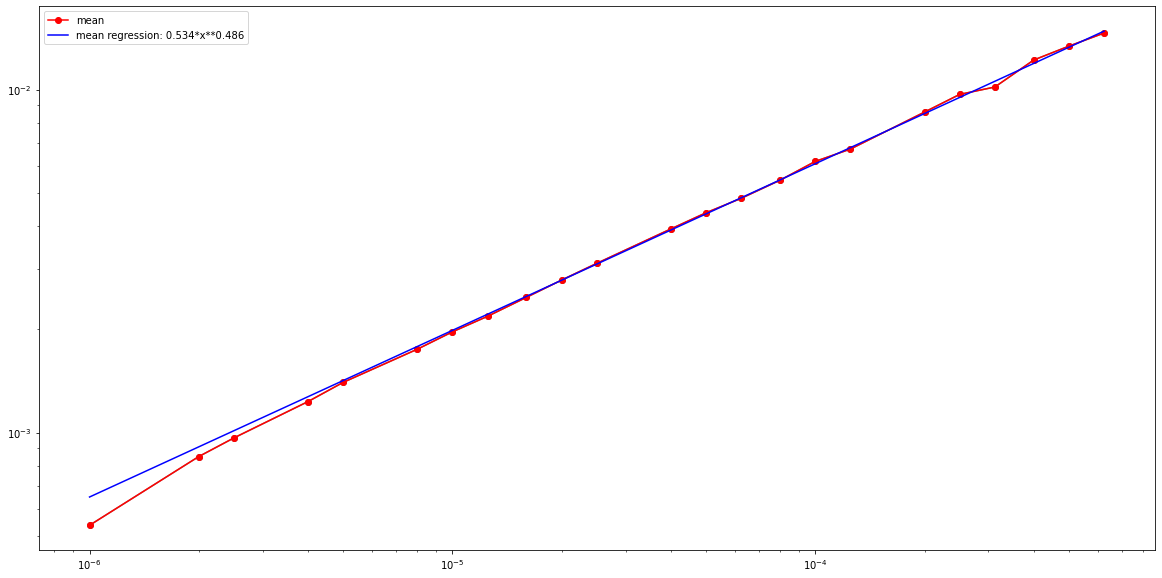

In [40]:
fig_linear = plt.figure(figsize=(20,10))
fig_log = plt.figure(figsize=(20,10))
ax1 = fig_linear.gca()
ax2 = fig_log.gca()

zeroParticle = pseudoParticles[0]  #Highest resolution track
zeroZs = np.array(zeroParticle.zs)
zeroTs = np.array(zeroParticle.ts)
deltas = []

coarserParticles = pseudoParticles[1:] #all particles except the reference one
coarserResolutions = resolutions[1:] #all resolutions except the reference one

#realizationDeltas = []

for particle in coarserParticles:
    zs = np.array(particle.zs)
    ts = np.array(particle.ts)
    zs_interpolated = np.interp(zeroTs, ts, zs)
    delta = np.linalg.norm(zeroZs - zs_interpolated, ord = 2)
    deltas.append(delta)
    #plt.figure(figsize=(20,10))
    #plt.scatter(zeroTs, (zeroZs - zs_interpolated)**2, color = "yellow", label ="difference")
    #plt.scatter(zeroTs, zeroZs, s= 0.5, color = "green", label = "base resolution")
    #plt.scatter(zeroTs, zs_interpolated, s= 0.5, color = "red", label = "interpolated")
    #plt.scatter(ts, zs, s= 2,color = "blue", label = "original")
    #plt.legend()
    #plt.title(f"dt = {particle.dt}")
##realizationDeltas.append(np.array(deltas))

ax1.plot(coarserResolutions, deltas, color = "grey", marker = "o")
ax2.loglog(coarserResolutions, deltas, color = "grey", marker = "o")

#realizationDeltasMean = np.mean(np.array(realizationDeltas), axis = 0) #construct array of len(deltas) that contains the average of all realizationDeltas at every point (expectation as n goes to infinity)

def power(x,a,b):
    return a * np.power(x, b)
popt, pcov = curve_fit(power, coarserResolutions, deltas)

ax1.plot(coarserResolutions, deltas, marker = "o", color = "red", label = "mean")
ax1.plot(coarserResolutions, power(coarserResolutions, *popt), 'b-', label="mean regression: {0:.3f}*x**{1:.3f}".format(*popt))
ax2.loglog(coarserResolutions, deltas, marker = "o", color = "red", label = "mean")
ax2.loglog(coarserResolutions, power(coarserResolutions, *popt), 'b-', label="mean regression: {0:.3f}*x**{1:.3f}".format(*popt))
plt.legend()

## Point

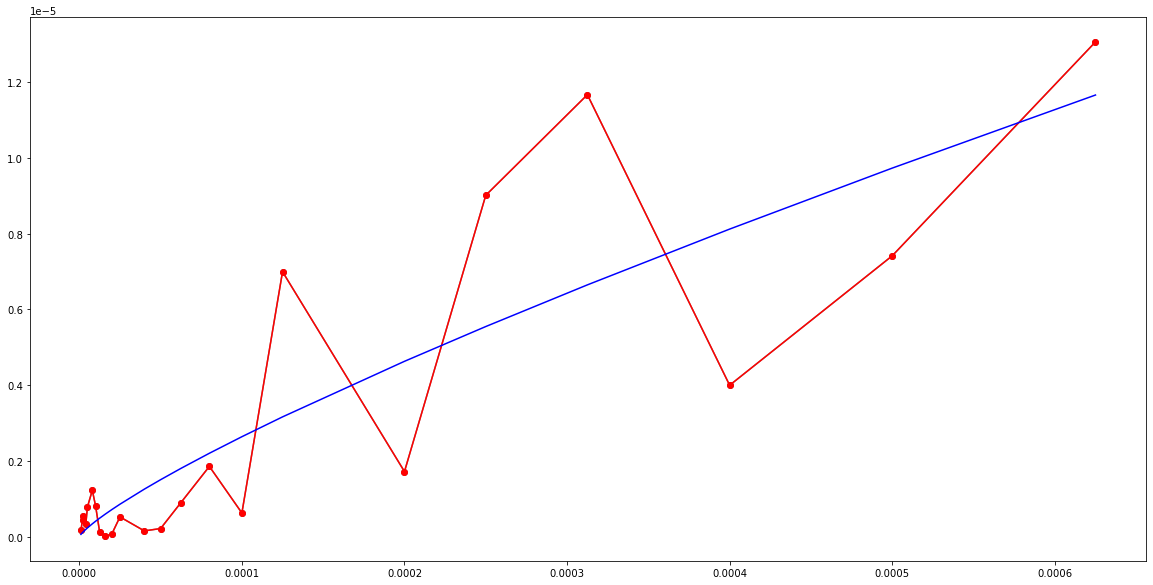

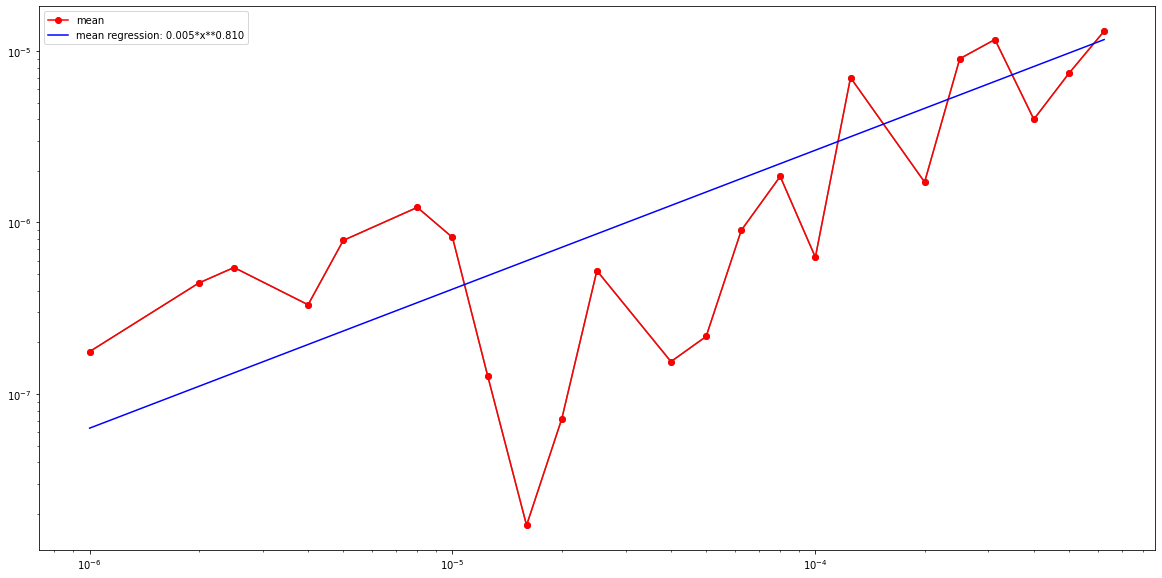

In [39]:
fig_linear = plt.figure(figsize=(20,10))
fig_log = plt.figure(figsize=(20,10))
ax1 = fig_linear.gca()
ax2 = fig_log.gca()

zeroParticle = pseudoParticles[0]  #Highest resolution track
zeroZs = np.array(zeroParticle.zs)
zeroTs = np.array(zeroParticle.ts)
deltas = []

coarserParticles = pseudoParticles[1:] #all particles except the reference one
coarserResolutions = resolutions[1:] #all resolutions except the reference one

#realizationDeltas = []

for particle in coarserParticles:
    zs = np.array(particle.zs)
    ts = np.array(particle.ts)
    zs_interpolated = np.interp(zeroTs, ts, zs)
    delta = abs(zeroZs[-1]**2 - zs[-1]**2)
    deltas.append(delta)
    #plt.figure(figsize=(20,10))
    #plt.scatter(zeroTs, (zeroZs - zs_interpolated)**2, color = "yellow", label ="difference")
    #plt.scatter(zeroTs, zeroZs, s= 0.5, color = "green", label = "base resolution")
    #plt.scatter(zeroTs, zs_interpolated, s= 0.5, color = "red", label = "interpolated")
    #plt.scatter(ts, zs, s= 2,color = "blue", label = "original")
    #plt.legend()
    #plt.title(f"dt = {particle.dt}")
##realizationDeltas.append(np.array(deltas))

ax1.plot(coarserResolutions, deltas, color = "grey", marker = "o")
ax2.loglog(coarserResolutions, deltas, color = "grey", marker = "o")

#realizationDeltasMean = np.mean(np.array(realizationDeltas), axis = 0) #construct array of len(deltas) that contains the average of all realizationDeltas at every point (expectation as n goes to infinity)

def power(x,a,b):
    return a * np.power(x, b)
popt, pcov = curve_fit(power, coarserResolutions, deltas)

ax1.plot(coarserResolutions, deltas, marker = "o", color = "red", label = "mean")
ax1.plot(coarserResolutions, power(coarserResolutions, *popt), 'b-', label="mean regression: {0:.3f}*x**{1:.3f}".format(*popt))
ax2.loglog(coarserResolutions, deltas, marker = "o", color = "red", label = "mean")
ax2.loglog(coarserResolutions, power(coarserResolutions, *popt), 'b-', label="mean regression: {0:.3f}*x**{1:.3f}".format(*popt))
plt.legend()